- 保监会 分类模型 2 训练 

# 基本设置

In [4]:
##load packages, needed
# encoding=utf-8

import jieba
from jieba import analyse
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif 
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict

import pickle

%matplotlib inline
import numpy as np
import pandas as pd
import pre_cor
import dict_dbutils
import os
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from pandas.io import sql
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [5]:
class StatsFeatures_cor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.neg = set()
        f = open("corpus/neg_words.txt","r+", encoding='UTF-8')
        for content in f:
            self.neg.add(content.strip())
        f.close()
        
        self.company = set() # 公司
        f = open("corpus/insurance_company_20180803.txt","r+", encoding='UTF-8')
        for content in f:
            self.company.add(content.strip())
        f.close()

        self.regulators = set() # 监管机构及领导
        f = open("corpus/insurance_regulators_20180804.txt","r+", encoding='UTF-8')
        for content in f:
            self.regulators.add(content.strip())
        f.close()    
        
        #初始化字典liwc
        self.liwc = {} 
        f2 = open("corpus/scliwc.txt",'r', encoding = 'gb18030')
        for ii in f2:     #ii在scliwc.txt中循环
            i = ii.strip().split() 
            self.liwc[i[0]] = i[1:len(i)]
        f2.close      
        
        self.category = set()
        for i in list(self.liwc.values()):
            for j in i:
                self.category.add(j)         
        
    def fit(self, X, y=None):
        return self

    def getcnt(self,x):        
        return len(list(set(x)))

    def getnegcnt(self,x):
        negcnt = 0
        words = x.split()
        for w in words:
            if w in self.neg:
                negcnt = negcnt+1
        return negcnt
    
    def getorgcnttf(self,x):
        companycnt=0
        companytf=0
        regcnt = 0
        regtf = 0
        
        words = x.split()
        words_set=set(words)
        for w in words_set:
            if w in self.company:
                companycnt = companycnt+1
                companytf=companytf+words.count(w)
                
            if w in self.regulators:
                regcnt = regcnt+1
                regtf=regtf+words.count(w)            
                
        return companycnt, companytf, regcnt, regtf
    
    def transform(self, X):
        data = []
        for x in X:
            if len(x) == 0:
                length  = 1
            else :
                length = len(x)
                
            companycnt, companytf, regcnt, regtf=self.getorgcnttf(x)
            
#             words = x.split()
#             psy = []
#             for w in words:
#                 if w in self.liwc: #是否liwc字典包含分词结果列表words的哪些分词
#                     psy += self.liwc[w] 
            
#             cat_tf = []
#             for cat in self.category:
#                 cat_tf.append(psy.count(cat)) 
                
            data.append([len(x),self.getcnt(x),self.getcnt(x)/length,
                         self.getnegcnt(x),self.getnegcnt(x)/length,
                         companycnt, companytf, regcnt, regtf]) #  + cat_tf            
        return data

In [6]:
def getkeywords(X, N = 1000):
    '''
    训练时生成，合并所有记录，取N个关键词
    '''
    textrank = analyse.textrank

    text_combined = ' '.join(X)
    keywords = textrank(text_combined, topK = N)
    print('keywords num: ', len(keywords))
    if len(keywords) < N : 
        N  = len(keywords)

    if keywords:
        f = open("corpus/keywords.txt","w+", encoding='UTF-8')
        for content in keywords:
            content = content.strip()
            f.write(content + '\n')
        f.close()

In [7]:
class Statskeywords(BaseEstimator, TransformerMixin):
    
    def __init__(self, topk = 100):
        self.topk = topk
        
        self.keywords = set()
        f = open("corpus/keywords.txt","r+", encoding='UTF-8')
        num = 0
        for content in f:
            if num < topk:
                self.keywords.add(content.strip().replace('\n', ''))
            num += 1
        f.close() 
                
#         self.otherwords = ['保险业','保险行业','保费','险资','险企', # 行业
#                            '罚款', # 公司 
#                            '产品', '销售', '投保', '保单', '续保', # 产品
#                            '投诉','骗保','案例','快速理赔','快赔','赔付', # 消费
#                            '个股','港股','股市','股票','大盘','目标价','评级', # 资本
#                            '活动','扶贫','奖','批复' # 其他
#                           ]
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        '''
        文本中关键词的词频
        '''                        
        data = []
        for x in X:
            words = x.split()
            word_tf = []
            keycnt = 0
            for kw in self.keywords:
                word_tf.append(words.count(kw)) # 各个关键词的词频
                if kw in words:keycnt+=1
            word_tf.append(keycnt) # 关键词的个数
            
#             tw_tf = []
#             for tw in self.otherwords:
#                 tw_tf.append(words.count(tw))               
                
            data.append(word_tf ) # + tw_tf            
        return data        

## 上一版模型读入

In [8]:
# 上一版模型
from sklearn.externals import joblib
pipeline_old = joblib.load( "model/circ_8classifier_0815.pkl.z") 

# 导入数据

In [9]:
title = []
filename = 'data/titles1.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    title.append(f.strip().replace('\n', ''))
fid.close()
print(len(title))

14175


In [10]:
title[:2]

['中华保险 因未 按规定 报送 可疑交易 报告 遭 央行 罚 万', '中国人寿 北京 违法 欺骗 投保人 保险 金融 频道 首页 财经网']

In [11]:
content = []
filename = 'data/contents1.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    content.append(f.strip().replace('\n', ''))
fid.close()
print(len(content))
# content[:2]

14175


In [12]:
title_content = [t + ' ' + c for t,c in zip(title, content)]
print(len(title_content))

14175


In [13]:
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音'}

In [14]:
label = []
filename = 'data/labels.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    label.append(f.strip().replace('\n', ''))
fid.close()
print(len(label))
label[:5]

14175


['公司内部管理', '公司内部管理', '公司内部管理', '公司内部管理', '公司内部管理']

In [15]:
label = [label_dic[l] for l in label]
label[:5]

[5, 5, 5, 5, 5]

# 训练模型

## 分割训练集、测试集

In [16]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 9922
训练集-各类数量： Counter({8: 2776, 1: 1273, 2: 1245, 5: 1154, 7: 1133, 6: 1125, 4: 705, 3: 511})
测试集： 4253
测试集-各类数量： Counter({8: 1220, 1: 541, 2: 510, 7: 501, 5: 496, 6: 482, 4: 287, 3: 216})


## 生成词典

In [35]:
if 0: 
    from jieba import analyse
    getkeywords(title_content, N = 1000)

### 分类生成词典

In [14]:
# j = 1
N = 500
class_key_dict = {}
key_dict = {}
for j in range(1,9):
    str_list = [m for m,n in zip(title_content, label) if n == j]
    print(len(str_list))
    print(label.count(j))
    textrank = analyse.textrank
    text_combined = ' '.join(str_list)
    keywords = textrank(text_combined, topK = N)
    print('keywords num: ', len(keywords))
#     print('%s -- %s: '%(j, class_name_dict[j]) , keywords)
    class_key_dict[j] = keywords
    for key in keywords:
        if key not in key_dict:            
            key_dict[key] = 1
        else :
            key_dict[key] += 1
    

1814
1814
keywords num:  500
1755
1755
keywords num:  500
727
727
keywords num:  500
992
992
keywords num:  500
1650
1650
keywords num:  500
1607
1607
keywords num:  500
1634
1634
keywords num:  500
3677
3677
keywords num:  500


In [15]:
key_count_list = [k for k,v in key_dict.items() if v > 3]
print(len(key_count_list))
print(len(key_dict.values()))
print(list(key_dict.values()))

410
1499
[8, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 7, 8, 8, 8, 5, 1, 8, 8, 8, 8, 8, 8, 5, 8, 8, 6, 7, 3, 8, 8, 8, 8, 5, 6, 8, 8, 5, 7, 5, 3, 6, 6, 7, 2, 4, 7, 8, 6, 4, 8, 8, 8, 6, 7, 4, 7, 6, 8, 6, 1, 8, 4, 8, 8, 8, 5, 8, 5, 6, 8, 1, 7, 7, 8, 8, 7, 7, 6, 4, 1, 7, 2, 4, 8, 4, 8, 1, 5, 4, 4, 6, 8, 2, 8, 8, 8, 6, 8, 7, 8, 5, 6, 8, 8, 7, 4, 5, 5, 8, 7, 8, 7, 2, 7, 6, 6, 5, 3, 1, 6, 8, 8, 7, 3, 1, 8, 8, 4, 1, 7, 6, 1, 4, 1, 8, 7, 4, 4, 5, 6, 2, 1, 7, 5, 6, 3, 8, 6, 5, 8, 4, 5, 4, 2, 5, 5, 3, 3, 6, 3, 5, 8, 1, 3, 4, 8, 2, 8, 4, 6, 8, 8, 8, 6, 8, 8, 2, 6, 8, 2, 6, 7, 4, 8, 4, 7, 1, 8, 2, 5, 4, 7, 5, 7, 8, 3, 6, 4, 5, 4, 5, 2, 8, 2, 3, 8, 8, 8, 5, 4, 6, 1, 8, 1, 4, 6, 2, 7, 6, 7, 1, 5, 7, 5, 2, 5, 2, 2, 1, 8, 2, 5, 4, 1, 2, 6, 1, 7, 1, 1, 1, 7, 4, 5, 8, 2, 2, 6, 3, 1, 5, 6, 5, 4, 7, 2, 1, 6, 2, 7, 5, 8, 4, 2, 8, 6, 8, 2, 5, 2, 2, 8, 6, 7, 3, 2, 4, 8, 3, 2, 5, 7, 7, 2, 8, 6, 3, 1, 3, 1, 8, 2, 1, 4, 2, 3, 7, 7, 1, 6, 1, 4, 1, 4, 6, 4, 1, 8, 4, 8, 5, 2, 8, 2, 7, 5, 8, 8, 7, 4, 5, 4, 8, 5, 6, 

In [16]:
with pd.ExcelWriter('data/word_class_freq.xlsx') as writer:
    for j in class_key_dict:
        class_name = class_name_dict[j]
        tmp_data = pd.DataFrame(class_key_dict[j])
        tmp_data.columns = ['word']
        tmp_data['class_freq'] = tmp_data['word'].apply(lambda x: key_dict[x])
        tmp_data.to_excel(writer, class_name)
    writer.save() 

In [17]:
keywords = []
for j in range(1,9):
    print('%s --'%j)
    keyword_list = class_key_dict[j]
    print('去除前：', len(keyword_list))
    for k in key_count_list:        
        if k in keyword_list:
            keyword_list.remove(k)
    print('去除后：', len(keyword_list)) 
    
    keywords += keyword_list

keywords = list(set(keywords))
print(keywords[:10])
print('len(keywords): ', len(keywords))
f = open("corpus/keywords.txt","w+", encoding='UTF-8')
for content in keywords:
    content = content.strip()
    f.write(content + '\n')
f.close()    

1 --
去除前： 500
去除后： 169
2 --
去除前： 500
去除后： 138
3 --
去除前： 500
去除后： 207
4 --
去除前： 500
去除后： 217
5 --
去除前： 500
去除后： 161
6 --
去除前： 500
去除后： 253
7 --
去除前： 500
去除后： 221
8 --
去除前： 500
去除后： 191
['聘任', '市场化', '保额', '乱象', '知道', '暴雨', '水泥', '经纪', '投标', '主题']
len(keywords):  1089


## LDA: 主题模型选特征

In [30]:
def print_top_words(model, feature_names, n_top_words):
    #打印每个主题下权重较高的term
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    #打印主题-词语分布矩阵
    print(model.components_)

In [33]:
# from sklearn.decomposition import LatentDirichletAllocation

# tf_vectorizer  = CountVectorizer(max_df=0.95, min_df=2)
# tf = tf_vectorizer.fit_transform(X_train)

# lda = LatentDirichletAllocation(n_topics=100,
#                                 max_iter=1000,
#                                 learning_method='batch',
#                                 random_state=0)
# docres = lda.fit_transform(tf)
# lda.perplexity(tf)

2215.660897178133

In [52]:
# lda.transform(tf)

In [53]:
# lda.n_iter_

In [54]:
# len(tf.data), tf.data

# tf_feature_names = tf_vectorizer.get_feature_names()
# print(tf_feature_names[:10])
# len(tf_feature_names)

# n_top_words=20
# tf_feature_names = tf_vectorizer.get_feature_names()
# print_top_words(lda, tf_feature_names, n_top_words)

In [55]:
# docres

In [56]:
# lda.components_

In [57]:
# doc_topic_dist = lda.transform(tf)

In [58]:
# from time import time
# n_topics = [200,] #range(20, 75, 5)
# perplexityLst = [1.0]*len(n_topics)

# #训练LDA并打印训练时间
# lda_models = []
# for idx, n_topic in enumerate(n_topics):
#     lda = LatentDirichletAllocation(n_topics=100,
#                                     max_iter=1000,
#                                     learning_method='batch',
#                                     evaluate_every=200,
# #                                    perp_tol=0.1, #default                                       
# #                                    doc_topic_prior=1/n_topic, #default
# #                                    topic_word_prior=1/n_topic, #default
#                                     verbose=0)
#     t0 = time()
#     lda.fit(tf)
#     perplexityLst[idx] = lda.perplexity(tf)
#     lda_models.append(lda)
#     print("# of Topic: %d, " % n_topics[idx])
#     print("done in %0.3fs, N_iter %d, " % ((time() - t0), lda.n_iter_))
#     print("Perplexity Score %0.3f" % perplexityLst[idx])

In [ ]:
# #打印最佳模型
# best_index = perplexityLst.index(min(perplexityLst))
# best_n_topic = n_topics[best_index]
# best_model = lda_models[best_index]
# print("Best # of Topic: ", best_n_topic)

## xgboost

### train

In [17]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures_cor()),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=500))])),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9967748437814956


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

### test

In [18]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8676228544556783
             precision    recall  f1-score   support

          1       0.85      0.86      0.85       541
          2       0.83      0.77      0.80       510
          3       0.85      0.76      0.80       216
          4       0.85      0.81      0.83       287
          5       0.80      0.86      0.83       496
          6       0.92      0.93      0.92       482
          7       0.91      0.89      0.90       501
          8       0.89      0.91      0.90      1220

avg / total       0.87      0.87      0.87      4253

confusion_matrix: 
[[ 463   24    1    5    7    0    3   38]
 [  35  394    9   11   20   13    3   25]
 [   4   10  164    0   17    4    5   12]
 [   3    7    0  233   19    0    0   25]
 [   3   18    4   10  425    5   13   18]
 [   1    4    5    0    5  450    8    9]
 [   6    6    4    1   16   10  448   10]
 [  30   13    7   15   23    9   10 1113]]


In [19]:
# 上一版模型 
y_pred_class = pipeline_old.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.9130025864095932
             precision    recall  f1-score   support

          1       0.88      0.91      0.90       541
          2       0.88      0.81      0.84       510
          3       0.86      0.89      0.88       216
          4       0.89      0.87      0.88       287
          5       0.90      0.91      0.90       496
          6       0.94      0.97      0.95       482
          7       0.95      0.95      0.95       501
          8       0.94      0.94      0.94      1220

avg / total       0.91      0.91      0.91      4253

confusion_matrix: 
[[ 495   18    2    2    3    0    1   20]
 [  30  413   14    7   13    8    4   21]
 [   3    3  192    1    4    3    3    7]
 [   6    8    0  251   10    1    1   10]
 [   0   15    5    5  449    7    7    8]
 [   0    2    2    0    2  466    2    8]
 [   2    2    0    0   10    6  476    5]
 [  25    8    7   17    9    6    7 1141]]


### 概率分布

In [20]:
y_pred_prob = pipeline.predict_proba(X_test)

In [31]:
#list(y_pred_prob.max(axis = 1))

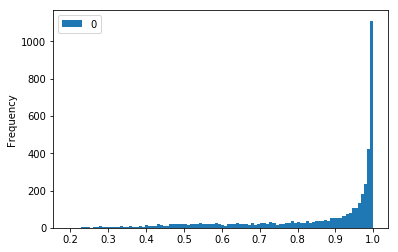

In [21]:
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

In [22]:
pipeline.classes_

array([1, 2, 3, 4, 5, 6, 7, 8])

proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,sum
predict_label,,,,,,,,,,
1,0.0,2.0,15.0,33.0,30.0,49.0,71.0,125.0,238.0,563.0
2,0.0,7.0,26.0,41.0,46.0,44.0,52.0,95.0,183.0,494.0
3,2.0,4.0,11.0,19.0,15.0,16.0,16.0,43.0,68.0,194.0
4,1.0,3.0,11.0,23.0,23.0,19.0,31.0,57.0,119.0,287.0
5,3.0,17.0,18.0,37.0,40.0,33.0,52.0,76.0,246.0,522.0
6,0.0,2.0,9.0,12.0,20.0,25.0,40.0,76.0,303.0,487.0
7,1.0,9.0,13.0,19.0,11.0,17.0,21.0,60.0,343.0,494.0
8,1.0,8.0,17.0,48.0,66.0,65.0,60.0,151.0,700.0,1116.0
sum,8.0,52.0,120.0,232.0,251.0,268.0,343.0,683.0,2200.0,4157.0


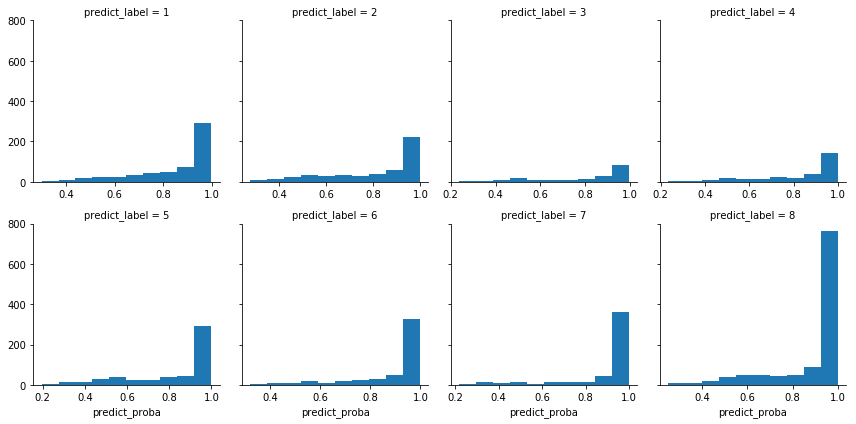

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sel_data = pd.DataFrame()
sel_data['predict_label'] = y_pred_class
sel_data['predict_proba'] = y_pred_prob.max(axis = 1)
sel_data['label'] = y_test

label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
# sel_data['predict_label'] = sel_data['predict_label'].apply(lambda x:label_dic[x])
g = sns.FacetGrid(sel_data, col="predict_label", col_wrap=4, sharex=False)
g.map(plt.hist, "predict_proba", bins = 10)

sel_data['proba'] = sel_data['predict_proba'].apply(lambda x:round(x, 1))
sel_data_stat = sel_data.groupby(['predict_label', 'proba'])['predict_proba'].count().unstack().fillna(0)
sel_data_stat['sum'] = sel_data_stat.sum(axis = 1)
sel_data_stat.loc['sum'] = sel_data_stat.sum(axis = 0)
sel_data_stat

### KFold

In [15]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=0)
title_content = np.array(title_content)
label = np.array(label)

In [16]:
num = 0
for train_index , test_index in kf.split(title_content):
    print('---- %s'%(num+1))
    X_train,X_test = title_content[train_index], title_content[test_index]
    y_train,y_test = label[train_index], label[test_index]
    
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('tf_idf', Pipeline([
                ('counts', CountVectorizer(max_df=0.95, min_df=2)),
                ('tf_idf', TfidfTransformer()),
                ('chi', SelectKBest(chi2, k=20000))
            ])),
            ('len_stats', StatsFeatures_cor()),
            ('tf', Pipeline([
                ('tf_k', Statskeywords(topk = 5000)),
                ('chi', SelectKBest(chi2, k=500))])),
        ])),
        ('standard', StandardScaler(with_mean=False)),
        ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
    ])
    pipeline.fit(X_train, y_train)
    print(pipeline.score(X_train, y_train))    
    
    y_pred_class = pipeline.predict(X_test)
    print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
    print(metrics.classification_report(y_test, y_pred_class))
    print('confusion_matrix: ')
    print( metrics.confusion_matrix(y_test, y_pred_class))    
    
    num += 1

---- 1
0.9964726631393298
accuracy_score:  0.8726489028213166
             precision    recall  f1-score   support

          1       0.84      0.87      0.85       329
          2       0.78      0.81      0.79       278
          3       0.90      0.76      0.82       150
          4       0.86      0.85      0.85       172
          5       0.86      0.83      0.84       265
          6       0.90      0.94      0.92       316
          7       0.92      0.92      0.92       346
          8       0.90      0.89      0.89       696

avg / total       0.87      0.87      0.87      2552

confusion_matrix: 
[[286  16   1   4   4   1   2  15]
 [ 16 225   4   4   7   6   1  15]
 [  1  11 114   0   5   3   6  10]
 [  3   5   0 146   6   0   0  12]
 [  3  15   3   3 219   9   7   6]
 [  0   3   4   0   3 297   5   4]
 [  3   4   0   0   7   4 320   8]
 [ 29  11   1  13   4  10   8 620]]
---- 2
0.9964726631393298
accuracy_score:  0.8793103448275862
             precision    recall  f1-score 

# 调参

In [38]:
score_1_best_para = {}
score_2_best_para = {}
cv = 3
score_1 = 'accuracy'
score_2 = 'recall_macro'

In [39]:
combined_features = Pipeline([
                        ('features', FeatureUnion([
                            ('tf_idf', Pipeline([
                                ('counts', CountVectorizer(max_df=0.95, min_df=2)),
                                ('tf_idf', TfidfTransformer()),
                                ('chi', SelectKBest(chi2, k=20000))
                            ])),
                            ('len_stats', StatsFeatures_cor()),
                            ('tf', Pipeline([
                                ('tf_k', Statskeywords(topk = 5000)),
                                ('chi', SelectKBest(chi2, k=500))])),
                        ])),
                        ('standard', StandardScaler(with_mean=False)),
                    ])

## topk、chi_k

In [42]:
pipeline = Pipeline([('process', combined_features), 
                     ('classifier', XGBClassifier(max_depth = 7, gamma = 0,
                                                  objective='multi:softmax', num_class=8))])

param_grid_0 = dict(process__features__tf_idf__chi__k = [2000, 5000, 20000, 40000 ],
                   process__features__tf__chi__k = [100, 300, 500, 800]) 
param_grid_0

{'process__features__tf_idf__chi__k': [2000, 5000, 20000, 40000],
 'process__features__tf__chi__k': [100, 300, 500, 800]}

In [43]:
clf = GridSearchCV(pipeline, param_grid=param_grid_0, 
                   cv = cv, scoring=score_1, n_jobs=-1, verbose=10)
clf.fit(X_train, y_train)
score_1_best_para['tf_idf__chi__k'] = clf.best_params_['process__features__tf_idf__chi__k']
score_1_best_para['tf__chi__k'] = clf.best_params_['process__features__tf__chi__k']
print('score_1_tf_idf__chi__k: ', score_1_best_para['tf_idf__chi__k'])
print('score_1_tf__chi__k: ', score_1_best_para['tf__chi__k'])
clf.grid_scores_, clf.best_params_, clf.best_score_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=2000 
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=2000 
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=2000 
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=2000, score=0.8501547987616099, total=18.5min
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=2000, score=0.8510046367851622, total=18.9min
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=2000, score=0.8695114409400123, total=18.9min
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=20000 
[CV]  process__

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 64.9min


[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=20000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=5000, score=0.8544891640866873, total=25.3min
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=40000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=20000, score=0.8553323029366307, total=31.5min
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=40000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=20000, score=0.8670377241805813, total=30.6min
[CV] process__features__tf__chi__k=100, process__features__tf_idf__chi__k=40000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=20000, score=0.8529411764705882, total=27.4min
[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=2000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=40000, score=0.8565687789799072, t

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 104.1min


[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=2000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=40000, score=0.8670377241805813, total=30.8min
[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=2000 
[CV]  process__features__tf__chi__k=100, process__features__tf_idf__chi__k=40000, score=0.8538699690402477, total=29.5min
[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=300, process__features__tf_idf__chi__k=2000, score=0.850386398763524, total=17.9min
[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=300, process__features__tf_idf__chi__k=2000, score=0.8642547928262214, total=18.4min
[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=300, process__features__tf_idf__chi__k=2000, score=0.8526315789473684, total=19

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 157.3min


[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=20000 
[CV]  process__features__tf__chi__k=300, process__features__tf_idf__chi__k=5000, score=0.8560371517027864, total=20.2min
[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=40000 
[CV]  process__features__tf__chi__k=300, process__features__tf_idf__chi__k=20000, score=0.8547140649149922, total=23.1min
[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=40000 
[CV]  process__features__tf__chi__k=300, process__features__tf_idf__chi__k=20000, score=0.865491651205937, total=21.7min
[CV] process__features__tf__chi__k=300, process__features__tf_idf__chi__k=40000 
[CV]  process__features__tf__chi__k=300, process__features__tf_idf__chi__k=20000, score=0.8513931888544891, total=22.0min
[CV] process__features__tf__chi__k=500, process__features__tf_idf__chi__k=2000 
[CV]  process__features__tf__chi__k=300, process__features__tf_idf__chi__k=40000, score=0.8550231839258114, to

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 203.7min


[CV] process__features__tf__chi__k=500, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=500, process__features__tf_idf__chi__k=2000, score=0.854095826893354, total=15.8min
[CV] process__features__tf__chi__k=500, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=500, process__features__tf_idf__chi__k=2000, score=0.8642547928262214, total=15.6min
[CV] process__features__tf__chi__k=500, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=500, process__features__tf_idf__chi__k=2000, score=0.8523219814241486, total=13.7min
[CV] process__features__tf__chi__k=500, process__features__tf_idf__chi__k=20000 
[CV]  process__features__tf__chi__k=500, process__features__tf_idf__chi__k=5000, score=0.8525502318392582, total=17.7min
[CV] process__features__tf__chi__k=500, process__features__tf_idf__chi__k=20000 
[CV]  process__features__tf__chi__k=500, process__features__tf_idf__chi__k=5000, score=0.8698206555349413, total=18

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 261.9min


[CV] process__features__tf__chi__k=800, process__features__tf_idf__chi__k=2000 
[CV]  process__features__tf__chi__k=500, process__features__tf_idf__chi__k=40000, score=0.8565687789799072, total=25.3min
[CV] process__features__tf__chi__k=800, process__features__tf_idf__chi__k=2000 
[CV]  process__features__tf__chi__k=500, process__features__tf_idf__chi__k=40000, score=0.8639455782312925, total=23.4min
[CV] process__features__tf__chi__k=800, process__features__tf_idf__chi__k=2000 
[CV]  process__features__tf__chi__k=800, process__features__tf_idf__chi__k=2000, score=0.8568778979907264, total=14.9min
[CV] process__features__tf__chi__k=800, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=500, process__features__tf_idf__chi__k=40000, score=0.8535603715170279, total=23.3min
[CV] process__features__tf__chi__k=800, process__features__tf_idf__chi__k=5000 
[CV]  process__features__tf__chi__k=800, process__features__tf_idf__chi__k=2000, score=0.8661100803957947, total=

[Parallel(n_jobs=-1)]: Done  46 out of  48 | elapsed: 346.7min remaining: 15.1min


[CV]  process__features__tf__chi__k=800, process__features__tf_idf__chi__k=40000, score=0.8645640074211502, total=20.3min
[CV]  process__features__tf__chi__k=800, process__features__tf_idf__chi__k=40000, score=0.8501547987616099, total=17.6min


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 361.5min finished


score_1_tf_idf__chi__k:  5000
score_1_tf__chi__k:  500


([mean: 0.85689, std: 0.00893, params: {'process__features__tf__chi__k': 100, 'process__features__tf_idf__chi__k': 2000},
  mean: 0.85761, std: 0.00751, params: {'process__features__tf__chi__k': 100, 'process__features__tf_idf__chi__k': 5000},
  mean: 0.85844, std: 0.00616, params: {'process__features__tf__chi__k': 100, 'process__features__tf_idf__chi__k': 20000},
  mean: 0.85916, std: 0.00568, params: {'process__features__tf__chi__k': 100, 'process__features__tf_idf__chi__k': 40000},
  mean: 0.85576, std: 0.00608, params: {'process__features__tf__chi__k': 300, 'process__features__tf_idf__chi__k': 2000},
  mean: 0.85854, std: 0.00498, params: {'process__features__tf__chi__k': 300, 'process__features__tf_idf__chi__k': 5000},
  mean: 0.85720, std: 0.00602, params: {'process__features__tf__chi__k': 300, 'process__features__tf_idf__chi__k': 20000},
  mean: 0.85761, std: 0.00664, params: {'process__features__tf__chi__k': 300, 'process__features__tf_idf__chi__k': 40000},
  mean: 0.85689, std

In [ ]:
pipeline = Pipeline([('process', combined_features), 
                     ('classifier', XGBClassifier(max_depth = 7, gamma = 0,
                                                  objective='multi:softmax', num_class=8))])

param_grid_0 = dict(process__features__tf_idf__chi__k = [2000, 5000, 20000, 40000 ],
                   process__features__tf__chi__k = [50,100, 500]) 
param_grid_0

In [ ]:
clf = GridSearchCV(pipeline, param_grid=param_grid_0, 
                   cv = cv, scoring=score_2, n_jobs=-1, verbose=10)
clf.fit(X_train, y_train)
score_2_best_para['tf_idf__chi__k'] = clf.best_params_['process__features__tf_idf__chi__k']
score_2_best_para['tf__chi__k'] = clf.best_params_['process__features__tf__chi__k']
print('score_2_tf_idf__chi__k: ', score_2_best_para['tf_idf__chi__k'])
print('score_2_tf__chi__k: ', score_2_best_para['tf__chi__k'])
clf.grid_scores_, clf.best_params_, clf.best_score_

## combined_features

In [44]:
combined_features_1 = Pipeline([
                        ('features', FeatureUnion([
                            ('tf_idf', Pipeline([
                                ('counts', CountVectorizer(max_df=0.95, min_df=2)),
                                ('tf_idf', TfidfTransformer()),
                                ('chi', SelectKBest(chi2, k=score_1_best_para['tf_idf__chi__k']))
                            ])),
                            ('len_stats', StatsFeatures_cor()),
                            ('tf', Pipeline([
                                ('tf_k', Statskeywords(topk = 5000)),
                                ('chi', SelectKBest(chi2, k=score_1_best_para['tf__chi__k']))])),
                        ])),
                        ('standard', StandardScaler(with_mean=False)),
                    ])

In [45]:
pipeline = Pipeline([('process', combined_features_1), 
                     ('classifier', XGBClassifier(max_depth = 7, gamma = 0, 
                                                  objective='multi:softmax', num_class=8))])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

0.9962882771419734
accuracy_score:  0.8638441183545826
             precision    recall  f1-score   support

          1       0.82      0.86      0.84       537
          2       0.81      0.77      0.79       526
          3       0.89      0.74      0.80       220
          4       0.83      0.80      0.81       290
          5       0.83      0.87      0.85       505
          6       0.91      0.94      0.92       470
          7       0.92      0.92      0.92       493
          8       0.89      0.89      0.89      1116

avg / total       0.86      0.86      0.86      4157

confusion_matrix: 
[[461  30   1   7   5   0   4  29]
 [ 34 405   6  15  16  15   1  34]
 [  4   8 162   1  12  11   6  16]
 [ 11   8   1 231  19   1   0  19]
 [  5  32   4   5 437   6   7   9]
 [  1   3   2   0   2 444   9   9]
 [  4   3   2   0  13   7 454  10]
 [ 45  10   5  20  21   6  12 997]]


In [46]:
combined_features_2 = Pipeline([
                        ('features', FeatureUnion([
                            ('tf_idf', Pipeline([
                                ('counts', CountVectorizer(max_df=0.95, min_df=2)),
                                ('tf_idf', TfidfTransformer()),
                                ('chi', SelectKBest(chi2, k=score_2_best_para['tf_idf__chi__k']))
                            ])),
                            ('len_stats', StatsFeatures_cor()),
                            ('tf', Pipeline([
                                ('tf_k', Statskeywords(topk = 5000)),
                                ('chi', SelectKBest(chi2, k=score_2_best_para['tf__chi__k']))])),
                        ])),
                        ('standard', StandardScaler(with_mean=False)),
                    ])

KeyError: 'tf_idf__chi__k'

In [ ]:
pipeline = Pipeline([('process', combined_features_2), 
                     ('classifier', XGBClassifier(max_depth = 7, gamma = 0, 
                                                  objective='multi:softmax', num_class=8))])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

## n_estimators、learning_rate

In [ ]:
pipeline = Pipeline([('process', combined_features_1), 
                     ('classifier', XGBClassifier(max_depth = 7, gamma = 0, 
                                                  objective='multi:softmax', num_class=8))])

param_grid_1 = dict(process__classifier__n_estimators = range(100,271,30), # 迭代次数/分类器个数
                   process__classifier__learning_rate=[0.01, 0.1, 0.3]) 
param_grid_1

In [ ]:
clf = GridSearchCV(pipeline, param_grid=param_grid_1, 
                   cv = cv, scoring=score_1, n_jobs=-1)
clf.fit(X_train, y_train)
score_1_best_para['n_estimators'] = clf.best_params_['process__classifier__n_estimators']
score_1_best_para['learning_rate'] = clf.best_params_['process__classifier__learning_rate']
print('score_1_n_estimators: ', score_1_best_para['n_estimators'])
print('score_1_learning_rate: ', score_1_best_para['learning_rate'])
clf.grid_scores_, clf.best_params_, clf.best_score_

In [ ]:
pipeline = Pipeline([('process', combined_features_1), 
                     ('classifier', XGBClassifier(max_depth = 7, gamma = 0, 
                                                  n_estimators = score_1_best_para['n_estimators'],
                                                  learning_rate = score_1_best_para['learning_rate'],                                                  
                                                  objective='multi:softmax', num_class=8))])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

In [ ]:
pipeline = Pipeline([('process', combined_features_2), 
                     ('classifier', XGBClassifier(max_depth = 7, gamma = 0, 
                                                  objective='multi:softmax', num_class=2))])

param_grid_1 = dict(process__classifier__n_estimators = range(30,161,20), # 迭代次数/分类器个数
                   process__classifier__learning_rate=[0.01, 0.1, 0.3]) 
param_grid_1

In [ ]:
clf = GridSearchCV(pipeline, param_grid=param_grid_1, 
                   cv = cv, scoring=score_2, n_jobs=-1)
clf.fit(X_train, y_train)
score_2_best_para['n_estimators'] = clf.best_params_['process__classifier__n_estimators']
score_2_best_para['learning_rate'] = clf.best_params_['process__classifier__learning_rate']
print('score_2_n_estimators: ', score_2_best_para['n_estimators'])
print('score_2_learning_rate: ', score_2_best_para['learning_rate'])
clf.grid_scores_, clf.best_params_, clf.best_score_

In [ ]:
pipeline = Pipeline([('process', combined_features_1), 
                     ('classifier', XGBClassifier(max_depth = 7, gamma = 0, 
                                                  n_estimators = score_2_best_para['n_estimators'],
                                                  learning_rate = score_2_best_para['learning_rate'],                                                  
                                                  objective='multi:softmax', num_class=8))])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

## max_depth、min_child_weight

In [ ]:
pipeline = Pipeline([('process', combined_features_1), 
                     ('classifier', XGBClassifier(n_estimators = score_1_best_para['n_estimators'],
                                                  learning_rate = score_1_best_para['learning_rate'],
                                                  objective='multi:softmax', num_class=2))])

param_grid_2 = dict(process__classifier__max_depth=range(3,14,2), # 决策树最大深度
                    process__classifier__min_child_weight=[4, 5, 6]) 
param_grid_2

In [ ]:
clf = GridSearchCV(pipeline, param_grid=param_grid_2, 
                   cv = cv, scoring=score_1, n_jobs=-1)
clf.fit(X_train, y_train)
score_1_best_para['max_depth'] = clf.best_params_['process__classifier__max_depth']
score_1_best_para['min_child_weight'] = clf.best_params_['process__classifier__min_child_weight']
print('score_1_max_depth: ', score_1_best_para['max_depth'])
print('score_1_min_child_weight: ', score_1_best_para['min_child_weight'])
clf.grid_scores_, clf.best_params_, clf.best_score_

In [ ]:
pipeline = Pipeline([('process', combined_features_1), 
                     ('classifier', XGBClassifier(gamma = 0, 
                                                  n_estimators = score_1_best_para['n_estimators'],
                                                  learning_rate = score_1_best_para['learning_rate'],        
                                                  max_depth = score_1_best_para['max_depth'],
                                                  min_child_weight = score_1_best_para['min_child_weight'],                                                   
                                                  objective='multi:softmax', num_class=8))])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

In [ ]:
score_1_best_para

In [ ]:
combined_features_1 = Pipeline([
                        ('features', FeatureUnion([
                            ('tf_idf', Pipeline([
                                ('counts', CountVectorizer(max_df=0.95, min_df=2)),
                                ('tf_idf', TfidfTransformer()),
                                ('chi', SelectKBest(chi2, k=20000))
                            ])),
                            ('len_stats', StatsFeatures_cor()),
                            ('tf', Pipeline([
                                ('tf_k', Statskeywords(topk = 5000)),
                                ('chi', SelectKBest(chi2, k=500))])),
                        ])),
                        ('standard', StandardScaler(with_mean=False)),
                    ])

In [ ]:
pipeline = Pipeline([('process', combined_features_1), 
                     ('classifier', XGBClassifier(gamma = 0, 
                                                  n_estimators = 160,
                                                  learning_rate = 0.1,        
                                                  max_depth = 5,
                                                  min_child_weight = 4,                                                   
                                                  objective='multi:softmax', num_class=8))])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

# 模型保存

In [22]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/circ_8classifier_0822.pkl.z")

['model/circ_8classifier_0822.pkl.z']

# 保存本文件

In [56]:
if 0:
    import datetime as dt
    
    def output_HTML(read_file, output_file):
        from nbconvert import HTMLExporter
        import codecs
        import nbformat
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    html_file_folder = 'html_files'
    if not os.path.exists(html_file_folder):
        os.makedirs(html_file_folder)

    today = dt.datetime.now().strftime('%Y%m%d')
    current_file = 'circ_cor_model_2_train.ipynb'
    output_file = 'html_files\%s_%s.html'%(os.path.splitext(current_file)[0], today)
    output_HTML(current_file, output_file)